# Dimuon spectrum

This code is a columnar adaptation of [a ROOT tutorial](https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8py.html) showcasing the awkward array toolset, and utilizing FCAT histograms.

In [1]:
import uproot
import uproot_methods
import awkward
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
import concurrent.futures
import json

from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot

In [2]:

# Make 4 parallel threads
executor = concurrent.futures.ThreadPoolExecutor(4)

# Make a cache for uproot
cache = {}

# Get the sample metadata
samples = json.load( open('samples_dy.json') )



In [3]:
tstart = time.time()

files = [
    '/mnt/cms-data/store/group/lpctlbsm/NanoAODJMAR_2019_V1/Production/CRAB/DYJetsToLL_M-50_HT-100to200_TuneCP5_13TeV-madgraphMLM-pythia8/DYJetsToLLM-50HT-100to200TuneCP513TeV-madgraphMLM-pythia8RunIIFall17MiniAODv2-PU201712Apr2018/190312_200205/0000/nano102x_on_mini94x_2017_mc_NANO_9.root'
]

masshist = hist.Hist("Counts", hist.Bin("mass", r"$m_{\mu\mu}$ [GeV]", 70, 50, 120))

branches = ['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']



start_time = time.perf_counter()
nev = 0

prefix = '/mnt/cms-data/store/group/lpctlbsm/NanoAODJMAR_2019_V1/Production/CRAB/'

for sample in samples["samples"]:    
    name, xsec, nevents = sample['name'], sample['xsec'], sample['nevents']
    files = glob.glob(prefix + name + '/*/*/*/*.root')
    
    weight = xsec / nevents
    print ("processing sample: ", sample )

    for chunk in uproot.iterate(files, 'Events', branches, cache=cache,
                            entrysteps=500000,executor=executor,  namedecode='ascii'):
        print('.',end='')
        p4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(
            chunk.pop('Muon_pt'),
            chunk.pop('Muon_eta'),
            chunk.pop('Muon_phi'),
            chunk.pop('Muon_mass'),
        )
        muons = awkward.JaggedArray.zip(p4=p4, charge=chunk['Muon_charge'])

        twomuons = (muons.counts == 2)
        opposite_charge = (muons['charge'].prod() == -1)
        dimuons = muons[twomuons & opposite_charge].distincts()
        dimuon_mass = (dimuons.i0['p4'] + dimuons.i1['p4']).mass
        masshist.fill(mass=dimuon_mass.flatten(), weight=weight)

elapsed = time.time() - tstart

processing sample:  {'name': 'DYJetsToLL_M-50_HT-70to100_TuneCP5_13TeV-madgraphMLM-pythia8', 'xsec': 143.0, 'nevents': 9344037.0}
...............................................................................................................................................................................................................processing sample:  {'name': 'DYJetsToLL_M-50_HT-100to200_TuneCP5_13TeV-madgraphMLM-pythia8', 'xsec': 164.4, 'nevents': 14185757.0}
......................................................................................................................................................................................................................processing sample:  {'name': 'DYJetsToLL_M-50_HT-200to400_TuneCP5_13TeV-madgraphMLM-pythia8', 'xsec': 49.77, 'nevents': 11499275.0}
.....................................................................................................................................................................................proc

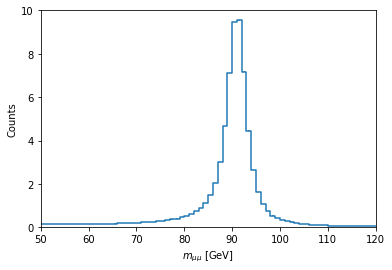

In [4]:
fig, ax, _ = plot.plot1d(masshist)

In [5]:
print("Events/s:", masshist.values()[()].sum()/elapsed)

Events/s: 0.04947333618276664
